In [1]:
import numpy as np
from scipy.optimize import minimize

from astropy.cosmology import LambdaCDM
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.table import Table
from astropy.visualization import quantity_support
quantity_support()

import matplotlib.pyplot as plt

# Load in cluster catalogs

## ACT catalog

(Opening the FITS file as an HDUL object)

In [2]:
# # open the catalog directly
# ACT_cat = fits.open('DR5_cluster-catalog_v1.1.fits')
# ACT_cat.info()
# ACT_cat.close()

# # open the catalog with context manger
# with fits.open('DR5_cluster-catalog_v1.1.fits') as hdul:
#     catalog = hdul[1].data
#     print('cluster names (length = 4195):')
#     print(catalog.field('name'))

(Opening the catalog as a table; see: https://docs.astropy.org/en/stable/io/unified.html#fits)

In [3]:
ACT_cat = Table.read('DR5_cluster-catalog_v1.1.fits', hdu = 1)

column = np.asarray(ACT_cat['decDeg'])
print(f'There are {len(column)} ACT clusters.')

There are 4195 ACT clusters.


## HSC catalog
Each row has 6 values: RA (degrees), Dec (degrees), z_cl, N_mem, logMs, and z_bcg; in that order. z_bcg = -1.0 indicates that the cluster has no identified BCG.

HSC_cat omits the last column of the data file, which lists the ID of a cluster.

In [4]:
HSC_cat_orig = np.loadtxt('camira_s19a_wide_v1.txt', # HSC catalog (sm = star mask)
                     usecols=(0,1,2,3,4,5)) 

# filter out low-richness clusters
good_richness = HSC_cat_orig[:,3] > 15
HSC_cat = HSC_cat_orig[good_richness]

print(f'There are {HSC_cat.shape[0]} HSC clusters.')

There are 6932 HSC clusters.


## Create SkyCoords

In [5]:
## SkyCoord objects for ACT and HSC
ACT_coords = SkyCoord(ra=ACT_cat['RADeg'] * u.degree, 
                      dec=ACT_cat['decDeg'] * u.degree, 
                      frame='icrs')
HSC_coords = SkyCoord(ra=HSC_cat[:,0] * u.degree, 
                      dec=HSC_cat[:,1] * u.degree, 
                      frame='icrs')

# convert coords to (-pi, pi) radians
act_ra = ACT_coords.ra.wrap_at(180 * u.deg).radian
act_dec = ACT_coords.dec.radian
hsc_ra = HSC_coords.ra.wrap_at(180 * u.deg).radian
hsc_dec = HSC_coords.dec.radian

## Define some boolean masks and print catalog counts

In [6]:
## Some ACT catalog counts

in_hsc_footprint = ACT_cat['footprint_HSCs19a']
print('Number of ACT clusters in HSC footprint: ' + 
      str(np.sum(in_hsc_footprint)))

has_hsc_counterpart = ACT_cat['CAMIRA']
print('Number of ACT clusters cross-matched with CAMIRA: ' + 
      str(np.sum(has_hsc_counterpart)))


position_from_cam = (ACT_cat['opt_positionSource'] == 'CAMIRA')
print('Number of ACT clusters with positions from CAMIRA: ' + 
      str(np.sum(position_from_cam)))

print()

print('Number of ACT clusters in SDSS footprint: ' + 
      'N/A')

has_sdss_counterpart = ACT_cat['RM'] 
print('Number of ACT clusters cross-matched with RM (SDSS): ' + 
      str(np.sum(has_sdss_counterpart)))

position_from_sdss = (ACT_cat['opt_positionSource'] == 'RM')
print('Number of ACT clusters with positions from RM (SDSS): ' + 
      str(np.sum(position_from_sdss)))

print() 

in_des_footprint = ACT_cat['footprint_DESY3']
print('Number of ACT clusters in DES footprint: ' + 
      str(np.sum(in_des_footprint)))

has_des_counterpart = ACT_cat['RMDESY3']
print('Number of ACT clusters cross-matched with RM (DES): ' + 
      str(np.sum(has_des_counterpart)))

position_from_des = (ACT_cat['opt_positionSource'] == 'RMDESY3') | \
                    (ACT_cat['opt_positionSource'] == 'RMDESY3ACT')
print('Number of ACT clusters with positions from RM (DES): ' + 
      str(np.sum(position_from_des)))

Number of ACT clusters in HSC footprint: 185
Number of ACT clusters cross-matched with CAMIRA: 212
Number of ACT clusters with positions from CAMIRA: 61

Number of ACT clusters in SDSS footprint: N/A
Number of ACT clusters cross-matched with RM (SDSS): 992
Number of ACT clusters with positions from RM (SDSS): 482

Number of ACT clusters in DES footprint: 1845
Number of ACT clusters cross-matched with RM (DES): 1689
Number of ACT clusters with positions from RM (DES): 1206


# Plot centering offsets (ACT-HSC)

Below, `get_physical_sep` calculates the physical separation between two objects at the same redshift.

In [7]:
def get_physical_sep(cosmo, theta, z):
    '''
    
    For two objects at the same redshift, calculate their physical separation 
    R as R = theta * d_A, where theta is angular separation (in radians) and 
    d_A is angular distance.
    
    ARGUMENTS
    ----------
    cosmo: model for cosmology; e.g. astropy.cosmology.LambdaCDM(...)
    theta: angular separation; should be a Quantity 
    z: redshift
    
    '''
    
    theta = theta.to(u.rad) / u.rad
    return theta * cosmo.angular_diameter_distance(z)

Note: Let $d_p$ be proper distance. Since $d_p \propto c/H_0$, $d_p$ as a function of $h$ (using $h \equiv \frac{H_0}{100 \text{ km/s/Mpc}}$) is $d_p(h) = h^{-1} d_p(h=1)$.

In [8]:
## Testing get_physical_sep

# h = 0.7
# temp_cosmo = LambdaCDM(H0=100*h, Om0=0.3, Ode0=0.7)
# # temp_angle = 3 * u.arcmin
# # temp_z = 1
# # get_physical_sep(temp_cosmo, temp_angle, temp_z)

# theta_grid = np.linspace(0, 6, 50) * u.arcmin
# temp_offsets = get_physical_sep(temp_cosmo, theta_grid, z=0.3)

# fig = plt.figure(figsize=(10,7))
# plt.plot(theta_grid, temp_offsets, label='fixed z')
# plt.plot(theta_grid, np.ones(50) / h, label='offset=1 Mpc/h')
# plt.xlabel('Angle (arcminutes)')

# plt.legend()
# plt.show()

In [9]:
## Plot physical offset as a function of (theta, z)

# theta_grid = np.linspace(0., 5, 50)
# z_grid = np.linspace(0, 1.4, 50)
# theta_grid,z_grid = np.meshgrid(theta_grid, z_grid)
# theta_grid *= u.arcmin

# temp_offsets = get_physical_sep(temp_cosmo, theta_grid.ravel(), z_grid.ravel())
# temp_offsets = temp_offsets.reshape(theta_grid.shape)

# from mpl_toolkits.mplot3d import Axes3D

# fig = plt.figure(figsize=(10,10))
# ax = fig.add_subplot(111, projection='3d')

# ax.plot_surface(X=theta_grid, Y=z_grid, Z=temp_offsets, label="Offsets")
# ax.plot_surface(X=theta_grid, Y=z_grid, Z=np.ones(temp_offsets.shape) / h, \
#                 label="Offset = 1 Mpc / h")
# ax.set_xlabel('theta (arcmin)')
# ax.set_ylabel('redshift')
# ax.set_zlabel('physical offset (Mpc)')

# plt.show()

# Modeling the offset distribution

See CAMIRA paper, equation 9. Below, `offset_model` models the probability distribution of offsets, and `objective_fn` is the likelihood function.

In [52]:
h = 0.7

In [79]:
def normal_pdf(x, mu=0, sigma=1):
    '''
    The probability density function of a normal/Gaussian distribution.
    
    ARGUMENTS
    ---------
    x: input
    mu: mean
    sigma: standard deviation
    
    '''
    
    scaling = 1 / sigma / np.sqrt(2 * np.pi)
    return scaling * np.exp(-0.5 * ((x - mu) / sigma)**2)

def offset_model(x, f_cen, sigma, tau):
    '''
    
    A two-component model for the centering offset distribution. 
    
    This model comes from the redMaPPer miscentering paper (Zhang et al. 2019).
    It models the well-centered clusters with an exponential and the miscentered
    clusters with a Gamma distribution.
    
    Returns the probability density at a given offset x = r_offset / R_lambda,
    where r_offset is the physical offset in Mpc while R_lambda depends on richness. 
    All arguments are dimensionless.
    
    ARGUMENTS
    ---------
    x: scaled offset; depends on richness and is defined to be dimensionless
    f_cen: fraction of well-centered clusters
    sigma: characteristic offset for well-centered clusters
    tau: characteristic offset for miscentered clusters
    
    '''

    prob_dens_well = np.exp(-x / sigma) / sigma
    prob_dens_mis = np.exp(-x / tau) * x / tau**2
    
    return f_cen * prob_dens_well + (1 - f_cen) * prob_dens_mis

def objective_fn(params, scaled_offsets):
    '''
    
    Given the model parameters and the set of offsets, compute
    the objective as a log likelihood.
    
    ARGUMENTS
    ----------
    params: tunable parameters in offset_model
    offsets: set of physical offsets (Mpc; same as offset_model)
    
    '''
    
    f_cen, sig, tau = params
    probs = offset_model(scaled_offsets, f_cen, sig, tau)
    obj = -np.sum(np.log(probs)) # maximize log likelihood
    
    return obj

## ACT clusters with CAMIRA, SDSS, or DES positions

**Note about `optSource == 'CAMIRA'` sample:** There are 61 ACT clusters that are flagged as having their optical position coming from CAMIRA, and 56 of them have valid optical positions in the catalog. (The other 5 were probably added after using CAMIRA in scanning mode; i.e. they weren't originally in the catalog, but were added based on ACT information.)

**Note about `optSource == 'DES'` sample:** 4/1064 of the clusters have a position, but no richness. If a richness-dependent offset model is being used, these clusters are omitted. 

In [117]:
## Create optical and SZ position catalogs

# get indices of the clusters with optical coordinates
optSource = 'CAMIRA'

if optSource == 'CAMIRA':
    opt_coord_locs = position_from_cam & (ACT_cat['opt_RADeg'] != -99)
elif optSource == 'SDSS':
    opt_coord_locs = position_from_sdss & (ACT_cat['opt_RADeg'] != -99)
elif optSource == 'DES':
    opt_coord_locs = position_from_des & (ACT_cat['opt_RADeg'] != -99) & \
        (ACT_cat['RMDESY3_LAMBDA_CHISQ'] != -99)
else:
    raise Exception('optSource must be CAMIRA, SDSS, or DES')
    
opt_ra = ACT_cat['opt_RADeg'][opt_coord_locs]
opt_dec = ACT_cat['opt_decDeg'][opt_coord_locs]

opt_coords = SkyCoord(ra=opt_ra * u.degree, 
                      dec=opt_dec * u.degree, 
                      frame='icrs')
sz_coords = ACT_coords[opt_coord_locs]

## Check that every cluster in the sample has a richness
# print(f'Number in sample with coords: {np.sum(opt_coord_locs)}')
# has_richness = ACT_cat[opt_coord_locs]['RMDESY3_LAMBDA_CHISQ'] > 0
# print(f'Number in sample with richnesses: {np.sum(has_richness)}')
# print('Clusters without richnesses:')
# print(ACT_cat[opt_coord_locs][~has_richness])

Check that the properties of this subsample are generally consistent with those of the full ACT sample. 
One observation: for CAMIRA, the `has_opt_coords` sample doesn't have large values of RM_LAMBDA and SNR.

In [118]:
## histograms of subsample and sample properties

# prop = 'RM_LAMBDA'
# plt.figure(figsize=(10,5))
# plt.title(f"Normalized distributions of " + prop + " for has_opt_coords and full sample")

# num_bins = 15
# bins = np.linspace(0, np.max(ACT_cat[prop]), num=num_bins)
# plt.hist(ACT_cat[prop], bins=bins, alpha=0.5, label='Full ACT sample', density=True)
# plt.hist(ACT_cat[opt_coord_locs][prop], bins=bins, alpha=0.5, \
#          label='Clusters with ' + optSource + ' positions', density=True)
# plt.xlabel(prop)
# plt.ylabel("Density")

# plt.legend()
# plt.show()

Fit the offset distribution.

In [119]:
## Calculate physical offsets
h = 0.7
cosmo = LambdaCDM(H0=100*h, Om0=0.3, Ode0=0.7)
angular_sep = opt_coords.separation(sz_coords)
redshifts = ACT_cat[opt_coord_locs]['redshift']
physical_sep = get_physical_sep(cosmo, angular_sep, redshifts)
physical_offsets = physical_sep.value # removes astropy units

if optSource == 'CAMIRA':
    richnesses = ACT_cat[opt_coord_locs]['CAMIRA_N_mem']
elif optSource == 'SDSS':
    richnesses = ACT_cat[opt_coord_locs]['RM_LAMBDA']
elif optSource == 'DES':
    richnesses = ACT_cat[opt_coord_locs]['RMDESY3_LAMBDA_CHISQ']
    
h = 0.7
R_lambda = (richnesses / 100)**0.2 / h
scaled_offsets = physical_offsets / R_lambda

In [120]:
## Estimate f_centered with an arbitrary cutoff for being well-centered
# def get_f_centered(well_centered_cutoff, matching_radius):
#     '''
    
#     Returns an estimate of f_centered.
    
#     ARGUMENTS
#     ---------
#     well_centered_cutoff: upper offset limit for well-centered clusters
#     matching_radius: upper offset limit for all clusters in sample
    
#     '''
    
#     num_well_centered = np.sum(offsets < well_centered_cutoff)
#     num_within_rad = np.sum(offsets < matching_radius)
    
#     return np.round(num_well_centered / num_within_rad, 2)

# well_centered_cutoff = 0.2 / h
# matching_radii = [.6, .7, .8, .9, 1, 10]
# print(f'Well-centered fraction (i.e. below {np.round(well_centered_cutoff, 2)} Mpc) for ' +\
#      optSource + ':')

# for matching_rad in matching_radii:
#     frac = get_f_centered(well_centered_cutoff, matching_rad)
#     print(f'Matching radius = {matching_rad} Mpc: {frac}')

In [121]:
## Remove an arbitrary number of large offsets
# offsets.sort()
# num_removed = 10
# offsets = offsets[:-num_removed]

In [122]:
## Optimize (has_opt_coords)
initial_guess = (0.75, 0.03, 0.17)
best_guess = minimize(fun=objective_fn, x0=initial_guess, args=(scaled_offsets), \
                     method='L-BFGS-B', bounds=((0.3, 1), (1e-4, 0.1), (0.08, 0.5)))

# init_obj = objective_fn(initial_guess, offsets)
# print(f'Initial obj: {init_obj}\n')

f_best, sig_best, tau_best = best_guess.x
print(best_guess)

      fun: -27.27658567128723
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 5.81469273e+00, -1.71586450e+01,  7.10542736e-07])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 36
      nit: 8
     njev: 9
   status: 0
  success: True
        x: array([0.3       , 0.1       , 0.13992155])


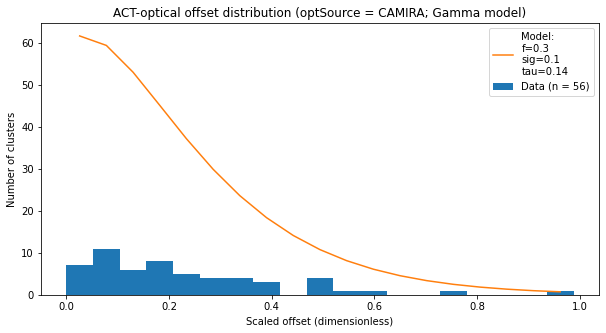

In [123]:
## Plot offset distro

plt.figure(figsize=(10,5))

plt.title(f"ACT-optical offset distribution (optSource = {optSource}; Gamma model)")

# Data
num_bins = 20
bins = np.linspace(0, np.max(scaled_offsets), num=num_bins)
hist = plt.hist(scaled_offsets, bins=bins, label=f"Data (n = {len(scaled_offsets)})")
plt.xlabel("Scaled offset (dimensionless)")
plt.ylabel("Number of clusters")

# Model
x_axis = (hist[1][:-1] + hist[1][1:]) / 2 # midpoints of histogram bins
model_scaling = 20 # scale model
y_axis = model_scaling * offset_model(x_axis, f_best, sig_best, tau_best)
plt.plot(x_axis, y_axis, label=\
         f"Model:\nf={np.round(f_best,3)}\nsig={np.round(sig_best,3)}\ntau={np.round(tau_best,3)}")

plt.legend()
plt.show()

# Cross-matching HSC and ACT clusters

The ACT catalog flags 212 ACT clusters as having a cross-match with HSC (via CAMIRA). Here, we get their CAMIRA positions.

In [45]:
def get_good_inds(idx, d2d, d3d):
    '''
    This function aims to remove duplicates from the results of an 
    asymmetric cross-match.
    
    Given idx, d2d, and d3d from astropy's match_to_catalog_sky function,
    return the 'good' indices in idx as a boolean array. (Here, bad means
    that an index in idx is matched to an object that already has a better 
    match in idx.)
    
    For example: if idx = (8, 8, 8) and d2d = (0.1, 0.3, 0.04), then we 
    accept the third element in idx and reject the two others. This 
    function then returns (False, False, True). 
    
    ARGUMENTS
    ---------
    idx, d2d, d3d: returns of astropy's match_to_catalog_sky function
    
    '''
    
    unique_idx, counts = np.unique(idx, return_counts=True)
    repeated_idxs = unique_idx[np.where(counts > 1)] # idxs appearing in idx multiple times
    good_ind = np.ones(idx.shape)
        
    for rep_idx in repeated_idxs:
        locs = np.where(idx == rep_idx)[0] # rep_idx's locations in idx
        best_loc = locs[0]
        
        for loc in locs:
            if d2d[loc] < d2d[best_loc]: best_loc = loc
        for loc in locs:        
            if loc != best_loc: good_ind[loc] = 0
    
    return good_ind == 1

In [49]:
# Note: idx indexes into HSC_coords
idx, d2d, d3d = ACT_coords[has_hsc_counterpart].match_to_catalog_sky(HSC_coords)
good_inds = get_good_inds(idx, d2d, d3d)

print(f'Number of ACT clusters flagged as having a match with HSC: {len(HSC_coords[idx])}')
print(f'Number of ACT clusters with a match (after removing duplicates): {np.sum(good_inds)}')

# Check for duplicates; ie, multiple ACT clusters being matched to the same HSC one
unique_idx, counts = np.unique(idx, return_counts=True)
print('\nIndices of HSC clusters with more than one match in ACT:')
print(np.where(counts > 1)[0])

Number of ACT clusters flagged as having a match with HSC: 212
Number of ACT clusters with a match (after removing duplicates): 210

Indices of HSC clusters with more than one match in ACT:
[ 85 204]


## Compute offsets and model the distribution

In [252]:
## Calculate physical offsets
h = 0.7
cosmo = LambdaCDM(H0=100*h, Om0=0.3, Ode0=0.7)

angular_sep = ACT_coords[has_hsc_counterpart][good_inds].separation(\
                        HSC_coords[idx[good_inds]])
redshifts = ACT_cat[has_hsc_counterpart][good_inds]['redshift']
physical_sep = get_physical_sep(cosmo, angular_sep, redshifts)

# remove large offsets
limit = 1 * u.Mpc / h
below_offset_limit = (physical_sep < limit)
offsets_Mpc = physical_sep[below_offset_limit]

offsets_Mpc.sort()
print(f'Largest offsets: {offsets_Mpc[-3:]}')

f_excluded = 1 - len(offsets_Mpc) / len(physical_sep)
print(f'Percent of offsets excluded: {np.round(f_excluded * 100, 2)}%')

## Fit the model
offsets = offsets_Mpc.value # "offsets" is unitless

# inject large offsets into the distribution
fake_offsets = np.linspace(0.5, 1.2, num=0)
offsets = np.concatenate((offsets, fake_offsets))
print(f'len(offsets): {len(offsets)}')

initial_guess = (0.68, 0.066, 0.37)
# Nelder-Mead is the only method in scipy.optimize.minimize that yields reasonable results
best_guess = minimize(fun=objective_fn, x0=initial_guess, args=(offsets), \
                     method='Nelder-Mead')

init_obj = objective_fn(initial_guess, offsets)
#print(f'Initial obj: {init_obj}\n')

f_best, sig1_best, sig2_best = best_guess.x
print(best_guess)

Largest offsets: [1.00105113 1.02423542 1.33242889] Mpc
Percent of offsets excluded: 0.95%
len(offsets): 208
 final_simplex: (array([[0.59062632, 0.08777571, 0.28580517],
       [0.59059889, 0.08776201, 0.28579793],
       [0.59053651, 0.08776205, 0.28578841],
       [0.59063552, 0.08776574, 0.28582244]]), array([7.97256920e-218, 7.97257065e-218, 7.97257360e-218, 7.97258263e-218]))
           fun: 7.972569202448669e-218
       message: 'Optimization terminated successfully.'
          nfev: 96
           nit: 51
        status: 0
       success: True
             x: array([0.59062632, 0.08777571, 0.28580517])


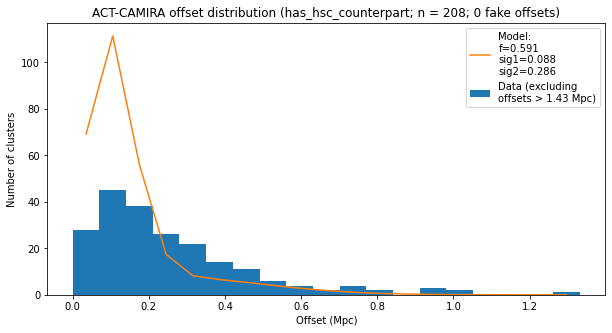

In [253]:
## Plot offset distribution (has_hsc_counterpart)
plt.figure(figsize=(10,5))
plt.title(f"ACT-CAMIRA offset distribution (has_hsc_counterpart; n = {len(offsets)}; {len(fake_offsets)} fake offsets)")

# Data
num_bins = 20
bins = np.linspace(0, np.max(offsets), num=num_bins)
hist = plt.hist(offsets, bins=bins, label=f"Data (excluding\noffsets > {np.round(limit,2)})")
plt.xlabel("Offset (Mpc)")
plt.ylabel("Number of clusters")

# Model
x_axis = (hist[1][:-1] + hist[1][1:]) / 2 # midpoints of histogram bins
norm_factor = 2. # normalize model
y_axis = norm_factor * offset_model(offset=x_axis, f_cen=f_best, sigma_1=sig1_best, sigma_2=sig2_best)
plt.plot(x_axis, y_axis, label=\
         f"Model:\nf={np.round(f_best,3)}\nsig1={np.round(sig1_best,3)}\nsig2={np.round(sig2_best,3)}")

plt.legend()
plt.show()

## Investigating why the well-centered fraction is low

Below, we make fake distributions and check that the model recovers the well-centered fraction.

In [216]:
temp1 = np.ones(30) * 0.1
temp2 = np.ones(20) * 0.2
temp3 = np.ones(15) * 0.9
temp4 = np.ones(35) * 1.3
temp_offsets = np.concatenate((temp1, temp2, temp3, temp4))

## Fit the model
initial_guess = (0.68, 0.066, 0.37)
# Nelder-Mead is the only method in scipy.optimize.minimize that yields reasonable results
best_guess = minimize(fun=objective_fn, x0=initial_guess, args=(temp_offsets), \
                     method='Nelder-Mead')

init_obj = objective_fn(initial_guess, offsets)
print(f'Initial obj: {init_obj}\n')

f_best, sig1_best, sig2_best = best_guess.x
print(best_guess)

Initial obj: 9.170846701680917e-171

 final_simplex: (array([[0.46022196, 0.08346289, 0.66423919],
       [0.46026881, 0.08346595, 0.66416856],
       [0.46029849, 0.08345663, 0.66430119],
       [0.46020704, 0.08345168, 0.66418825]]), array([9.36882645e-46, 9.36883815e-46, 9.36883894e-46, 9.36884040e-46]))
           fun: 9.368826451721663e-46
       message: 'Optimization terminated successfully.'
          nfev: 110
           nit: 61
        status: 0
       success: True
             x: array([0.46022196, 0.08346289, 0.66423919])


# Plotting info from TOPCAT 

## Number of matches vs. matching radius

I got the data below via TOPCAT's table-matching feature. I selected "Best match, symmetric" and "1 and 2" for Match Selection and Join Type, respectively. Then, I plugged in different matching radii using the Max error option.

In [2]:
## Plotting number of matches vs. match radius
# match_radius = [.1, .2, .3, .4, .5, \
#                 .6, .7, .8, .9, 1, \
#                1.1, 1.2, 1.3, 1.4, 1.5, \
#                2, 2.5, 3, 4, 5, 6, 7, \
#                10, 15] # arcmin
# num_matches = [6, 34, 48, 71, 94, \
#                107, 123, 142, 149, 157, \
#               162, 167, 170, 175, 178,
#               187, 190, 194, 201, 205, 210, 215, \
#               234, 247]

# plt.scatter(match_radius, num_matches)
# plt.xlabel('Matching radius (arcminutes)')
# plt.ylabel('Number of matches')

# plt.show()

# Plot clusters on the sky

Reference: https://het.as.utexas.edu/HET/Software/Astropy-1.0/coordinates/skycoord.html#example-1-plotting-random-data-in-aitoff-projection

## Plot full catalogs

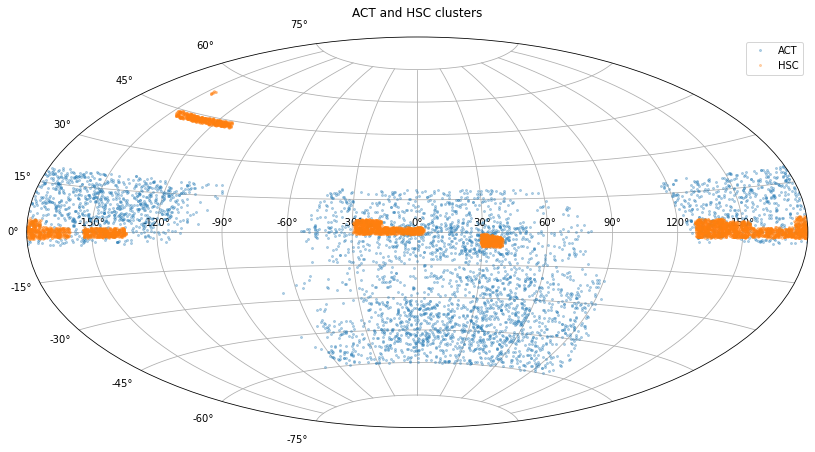

In [7]:
plt.figure(figsize=(14,9))

plt.subplot(111, projection="aitoff")
plt.grid(True)
plt.plot(act_ra, act_dec, 'o', markersize=2, alpha=0.3, label='ACT')
plt.plot(hsc_ra, hsc_dec, 'o', markersize=2, alpha=0.3, label='HSC')

plt.title("ACT and HSC clusters", pad=20)
plt.legend()
plt.show()

## Plot a random subset of ACT clusters

(playing around with matplotlib)

In [1]:
# size = len(act_ra)
# rand_inds = np.random.uniform(size=size) > 0.98

# fig = plt.figure(figsize=(16,10))

# ax = plt.subplot(111, projection="aitoff")
# ax.set_facecolor('#C3FFFF')
# plt.grid(True)
# # unicode 00a9 = copyright symbol
# plt.plot(act_ra[rand_inds], act_dec[rand_inds], marker='$\u00A9$', 
#          markersize=20, linestyle='None', alpha=0.5, label='ACT', c='r')

# plt.title("Random ~2% of ACT galaxy clusters", pad=25)
# plt.show()

## Plot ACT clusters cross-matched with HSC, SDSS, and/or DES

Number of ACT clusters cross-matched with CAMIRA (HSC): 212
Number of ACT clusters cross-matched with redMaPPer (SDSS and/or DES): 2510
Number of ACT clusters cross-matched with at least one of the catalogs: 2600



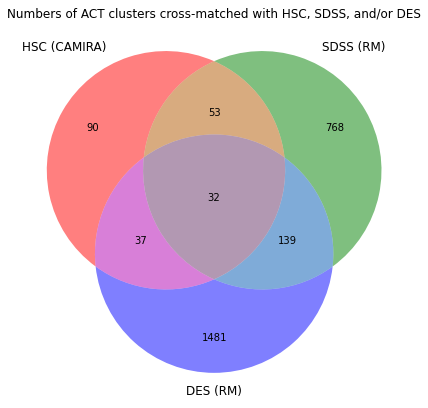

In [40]:
## Separate RM clusters based on if they have a counterpart:
# 1. only in one catalog,
# 2. in two catalogs, or 
# 3. in all three

has_hsc_counterpart = ACT_cat['CAMIRA']
has_sdss_counterpart = ACT_cat['RM'] 
has_des_counterpart = ACT_cat['RMDESY3']
print('Number of ACT clusters cross-matched with CAMIRA (HSC): ' + 
      str(np.sum(has_hsc_counterpart)))
print('Number of ACT clusters cross-matched with redMaPPer (SDSS and/or DES): ' + 
      str(np.sum(has_sdss_counterpart | has_des_counterpart)))
print('Number of ACT clusters cross-matched with at least one of the catalogs: ' + 
      str(np.sum(has_hsc_counterpart | has_sdss_counterpart | has_des_counterpart)))

print()

hsc_only = has_hsc_counterpart & (~has_sdss_counterpart) & (~has_des_counterpart)
sdss_only = (~has_hsc_counterpart) & has_sdss_counterpart & (~has_des_counterpart)
des_only = (~has_hsc_counterpart) & (~has_sdss_counterpart) & has_des_counterpart

hsc_sdss = has_hsc_counterpart & has_sdss_counterpart & (~has_des_counterpart)
sdss_des = (~has_hsc_counterpart) & has_sdss_counterpart & has_des_counterpart
hsc_des = has_hsc_counterpart & (~has_sdss_counterpart) & has_des_counterpart

hsc_sdss_des = has_hsc_counterpart & has_sdss_counterpart & has_des_counterpart

# 3-group Venn diagram showing #s of clusters in each category
from matplotlib_venn import venn3_unweighted

# order of subsets: A, B, AB, C, AC, BC, ABC
subsets = (np.sum(cam_only), np.sum(sdss_only), np.sum(cam_sdss), \
          np.sum(des_only), np.sum(cam_des), np.sum(sdss_des), \
          np.sum(cam_sdss_des))

plt.figure(figsize=(7,7))
plt.title("Numbers of ACT clusters cross-matched with HSC, SDSS, and/or DES")
venn3_unweighted(subsets = subsets, \
      set_labels = ('HSC (CAMIRA)', 'SDSS (RM)', 'DES (RM)'), \
      alpha = 0.5)

plt.show()

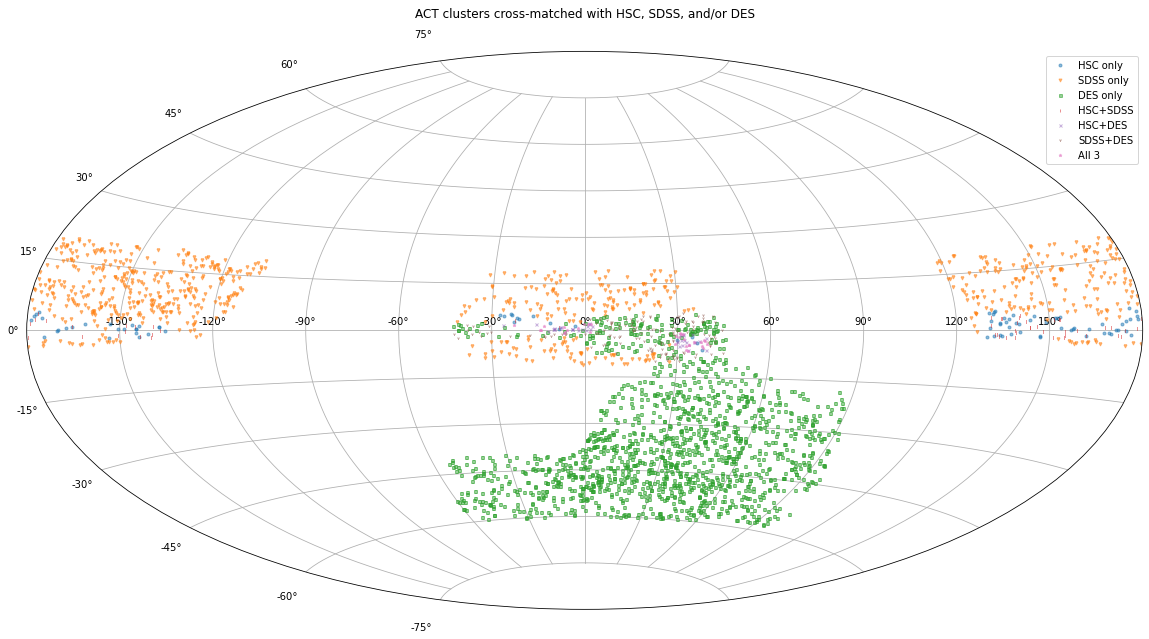

In [63]:
## Plot the different subsets

plt.figure(figsize=(20,13))

plt.subplot(111, projection="aitoff")
plt.grid(True)

plt.plot(act_ra[hsc_only], act_dec[hsc_only], 
         'o', markersize=3, alpha=0.5, label='HSC only')
plt.plot(act_ra[sdss_only], act_dec[sdss_only], 
         'v', markersize=3, alpha=0.5, label='SDSS only')
plt.plot(act_ra[des_only], act_dec[des_only], 
         's', markersize=3, alpha=0.5, label='DES only')

plt.plot(act_ra[hsc_sdss], act_dec[hsc_sdss], 
         '|', markersize=3, alpha=0.5, label='HSC+SDSS')
plt.plot(act_ra[hsc_des], act_dec[hsc_des], 
         'x', markersize=3, alpha=0.5, label='HSC+DES')
plt.plot(act_ra[sdss_des], act_dec[sdss_des], 
         '1', markersize=3, alpha=0.5, label='SDSS+DES')

plt.plot(act_ra[hsc_sdss_des], act_dec[hsc_sdss_des], 
         '*', markersize=3, alpha=0.5, label='All 3')

plt.title("ACT clusters cross-matched with HSC, SDSS, and/or DES", pad=40)
plt.legend()
plt.show()